In [6]:
import math
import random
import yaml
import argparse
from dotmap import DotMap

import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam

# import matplotlib.pyplot as plt
import wandb

import sys
sys.path.append("../src")  # make sure Python can find src/
import data
from model import GPTLinear, GPTSoftmax
from multi_task_train import train_step


def set_seed(seed: int):
    """Set all random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    ## Not sure if below would work if I dont have gpu
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seed set to {seed}")


def load_config(config_path: str):
    """Load YAML config and convert to DotMap."""
    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)
    cfg = DotMap(cfg)
    return cfg


def prepare_data_samplers(config, device):
    """Create a dict of data samplers for each task."""
    num_task = len(config.data.tasks)
    data_samplers = {}
    for task_config in config.data.tasks:
        task_name = task_config.name
        task_class = getattr(data, task_name)
        data_samplers[task_name] = {
            "sampler": task_class(task_config, device),
            "n_train": task_config.n_train,
            "n_test": task_config.n_test,
        }
    return data_samplers

In [31]:
config = load_config('../src/configs/mix1_mws_mwp.yaml')

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [33]:
seed = getattr(config.train, "seed", 42)
set_seed(seed)

Seed set to 67


In [34]:
n_tasks = len(config.data.tasks)
config.model.vocab_size = max(getattr(config.data, "p", 17), config.data.max_num) + n_tasks
config.model.block_size = 2 * config.data.num_tokens + 1

In [35]:
data_samplers = prepare_data_samplers(config, device)


In [36]:
data_samplers

{'MovingWindowSum': {'sampler': <data.moving_window_sum.MovingWindowSum at 0x137dd4d90>,
  'n_train': 128,
  'n_test': 32},
 'MovingWindowProduct': {'sampler': <data.moving_window_product.MovingWindowProduct at 0x137dd4bb0>,
  'n_train': 128,
  'n_test': 32}}

In [41]:
data_samplers['MovingWindowSum']['n_train'] = 56
data_samplers['MovingWindowSum']['n_test'] = 14

In [42]:
num_tokens = config.data.num_tokens

# --- MIXED BATCH SAMPLING ---
mixed_train = {}
mixed_test = {}

## Generate data for each task
for name, task_info in data_samplers.items():
    sampler = task_info["sampler"]
    n_train = task_info["n_train"]
    n_test = task_info["n_test"]

    data = sampler.sample(
        num_samples=n_train + n_test,
        num_tokens=num_tokens,
    )
    train_part = data[:n_train, :]
    test_part = data[n_train:, :]
    mixed_train[name] = train_part
    mixed_test[name] = test_part

## Mix task batches together
train_data = torch.cat(list(mixed_train.values()), dim=0)
test_data = torch.cat(list(mixed_test.values()), dim=0)

if config.data.mix == 'random':
    # optionally shuffle to fully mix across tasks
    perm = torch.randperm(train_data.size(0))
    train_data = train_data[perm]
    perm = torch.randperm(test_data.size(0))
    test_data = test_data[perm]

In [23]:
if config.train.freeze_embedding:
        for param in model.transformer.wte.parameters():
            param.requires_grad = False
        for param in model.transformer.wpe.parameters():
            param.requires_grad = False

In [27]:
 optim = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config.train.lr)

Error: You must call wandb.init() before wandb.log()

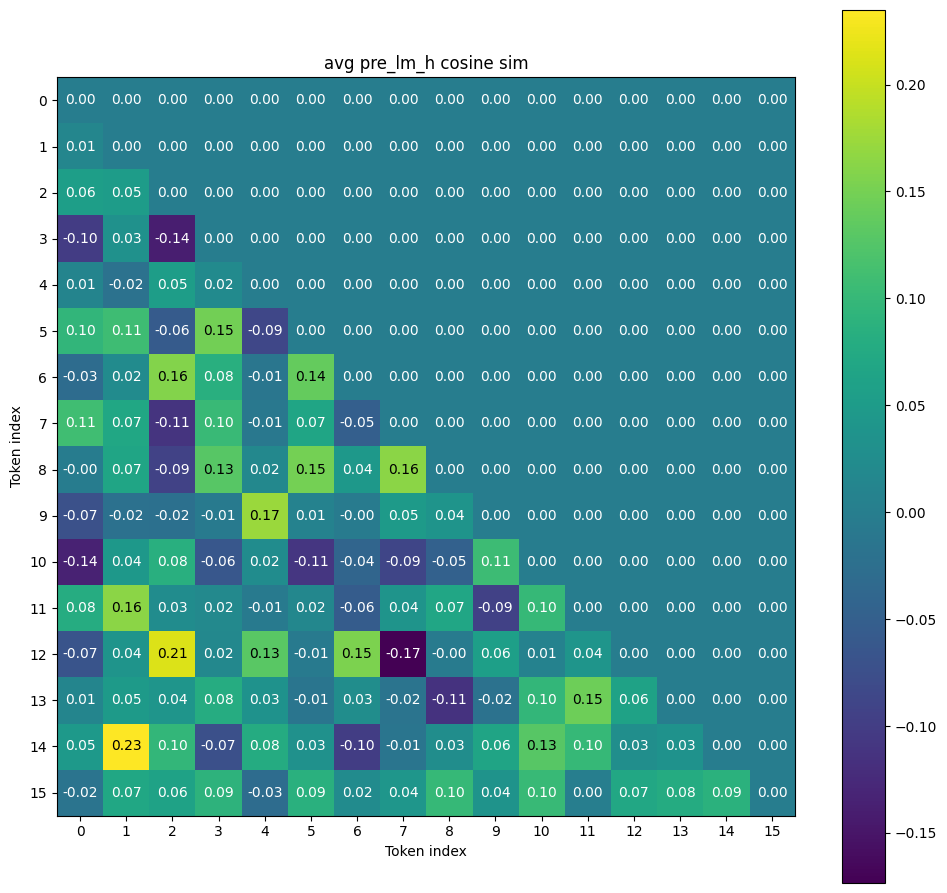

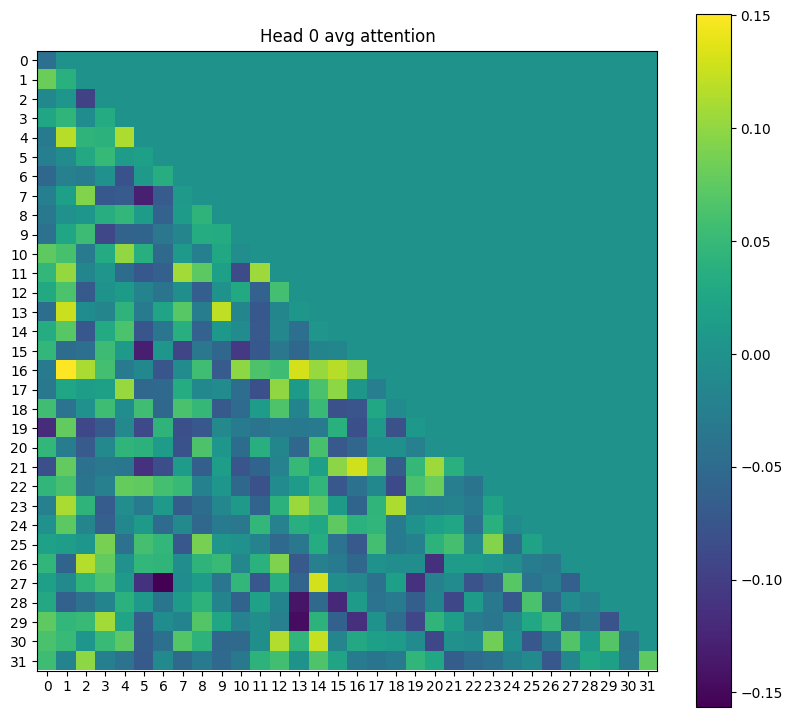

In [29]:
for step in range(config.train.num_steps):
    train_step(
        model=model,
        optim=optim,
        data_samplers=data_samplers,
        step=step,
        config=config,
        device=device,
    )